<div align="center">

# Final Project: Solar Installations in California

ECON 294A Python Lab, Spring 2024, UC Santa Cruz

Theo Dubus

</div>

# Summary

Home based solar energy systems are an increasingly important component of the electrical grid in Califnronia, and a rapidly expanding markt sector. In this analysis, I explore demographic factors that may influence households to adopt solar power at the county level across California using OLS regression and random forest techniques for feature importance. This data was originally gathered as part of my independent study into residential solar adoption rates around the 2018 wildfire events. However, I am taking a different approach with this analysis by omitting the effects of the wildfire events and looking solely at the factors affecting solar adoption across counties in 2019. 


# Data

Due to the truncated data I was able to gather, my analysis focuses on causal inference rather than machine learning prediction models that I had intended to use in the proposal. Nevertheless, it will be helpful in gaining preliminary insights into the major factors of solar energy adoption.

This data comes from two main sources: 

1. Demographic data was downloaded from the American Community Survey 5-Year estimates for 2019. Vairables include:
    - Median age of house holder, which measures only the head of household for the occupant of an owned or rented housing unit. This omits other factors in age like the presence of children, looking only at the age of those directly involved with the decison to adopt solar power for the property.
    - Median income
    - Percent of owners vs renters in the county
    - Education, measured seperately: percent of people who graduated high school, attained some college, and earned a bachelor's degree or higher.
    - Race: multiple racial groups were originionally downloaded in the data, but only 'Race_White' was kept to reduce bias in the estimates. Chnages in the white population are highly correlated with changes in multiple other groups simultaneously (for example, black and hispanic), so this caused too much self-correlation with the data.

2. Solar Installations per capita was calculated using the Distributed Generation Statistics dataset from the California Public Utilities Commission. Data was aggregated for each of the 53 counties studied in 2019. This was divided by the population in each county in 2019 gathered from the ACS.



In [159]:
# Load packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf


In [160]:
# Load data
TD0 = pd.read_csv('data/Test_Data_2.csv')


In [161]:
# Explore data
TD0.head()



,Unnamed: 0,FEMA,FEMA_Adjascent,Median_Income,Percent_Own,Med_Home_Price,IPC_BEFORE,IPC_AFTER,County,Median_Age_House_Holder,Educ_HS_Grad,Educ_Some_College,Educ_Bachelor_or_Higher,Race_White,Race_Black_AA,Race_American_Indian_and_Alaska_Native,Race_Asian,Race_Native_Hawaiian_and_Other_Pacific_Islander,Race_Hispanic_or_Latino_origin
0,1,0,0,49580,5.351755e-01,9.105000e+05,3.171129e-05,3.171129e-05,Alameda,49,1.440000e-01,2.490000e-01,5.180000e-01,4.680000e-01,1.240000e-01,7.000000e-03,2.730000e-01,7.000000e-03,1.640000e-01
1,3,0,0,35010,7.650404e-01,3.230000e+05,8.502717e-03,9.785671e-03,Amador,61,2.330000e-01,4.710000e-01,2.330000e-01,9.290000e-01,1.000000e-03,5.000000e-03,8.000000e-03,0.000000e+00,8.400000e-02
2,4,1,0,28642,5.899086e-01,3.588750e+05,9.740586e-03,1.341327e-02,Butte,53,1.920000e-01,4.350000e-01,2.920000e-01,8.700000e-01,1.200000e-02,1.200000e-02,3.100000e-02,1.000000e-03,1.160000e-01
3,5,0,0,30442,7.775351e-01,3.397500e+05,1.154558e-03,1.154558e-03,Calaveras,61,2.210000e-01,4.860000e-01,2.210000e-01,9.260000e-01,5.000000e-03,9.000000e-03,1.500000e-02,1.000000e-03,8.400000e-02
4,7,0,0,46590,6.592311e-01,6.625000e+05,5.066206e-03,5.424238e-03,Contra Costa,52,1.460000e-01,3.100000e-01,4.640000e-01,6.290000e-01,8.900000e-02,4.000000e-03,1.520000e-01,4.000000e-03,1.840000e-01


Summary statistics are below:

In [162]:
# Omit unnamed column and IPC_BEFORE (this is a legacy of my previous research)
TD1 = TD0[['IPC_AFTER', 'County', 'Median_Income' , 'Med_Home_Price', 'Percent_Own' , 'Median_Age_House_Holder' , 'Educ_Some_College' , 'Race_White']]
TD1 = TD1.rename(columns={'IPC_AFTER':'IPC'})
TD1.describe()

,IPC,Median_Income,Med_Home_Price,Percent_Own,Median_Age_House_Holder,Educ_Some_College,Race_White
count,5.300000e+01,5.300000e+01,5.300000e+01,5.300000e+01,5.300000e+01,5.300000e+01,5.300000e+01
mean,1.098371e-02,3.487194e+04,5.060961e+05,6.119705e-01,5.352830e+01,3.683774e-01,7.775094e-01
std,3.468783e-02,8.699457e+03,3.272905e+05,7.774408e-02,3.935068e+00,7.198564e-02,1.268017e-01
min,2.431098e-05,2.020600e+04,2.100000e+05,3.759832e-01,4.700000e+01,1.860000e-01,4.680000e-01
25%,1.154558e-03,2.877900e+04,2.846500e+05,5.683718e-01,5.000000e+01,3.300000e-01,6.710000e-01
50%,3.423149e-03,3.264700e+04,3.800000e+05,6.051453e-01,5.200000e+01,3.610000e-01,8.160000e-01
75%,6.972879e-03,3.849100e+04,6.500000e+05,6.537269e-01,5.700000e+01,4.210000e-01,8.900000e-01
max,1.931598e-01,5.946300e+04,1.610750e+06,7.775351e-01,6.100000e+01,4.930000e-01,9.380000e-01


Figure 1 below displays an overview of installations per capita across California counties in 2019. Two counties clearly stand out.

([0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33,
  34,
  35,
  36,
  37,
  38,
  39,
  40,
  41,
  42,
  43,
  44,
  45,
  46,
  47,
  48,
  49,
  50,
  51,
  52],
 [Text(0, 0, 'Alameda'),
  Text(1, 0, 'Amador'),
  Text(2, 0, 'Butte'),
  Text(3, 0, 'Calaveras'),
  Text(4, 0, 'Contra Costa'),
  Text(5, 0, 'Del Norte'),
  Text(6, 0, 'El Dorado'),
  Text(7, 0, 'Fresno'),
  Text(8, 0, 'Glenn'),
  Text(9, 0, 'Humboldt'),
  Text(10, 0, 'Imperial'),
  Text(11, 0, 'Kern'),
  Text(12, 0, 'Kings'),
  Text(13, 0, 'Lake'),
  Text(14, 0, 'Lassen'),
  Text(15, 0, 'Los Angeles'),
  Text(16, 0, 'Madera'),
  Text(17, 0, 'Marin'),
  Text(18, 0, 'Mariposa'),
  Text(19, 0, 'Mendocino'),
  Text(20, 0, 'Merced'),
  Text(21, 0, 'Mono'),
  Text(22, 0, 'Monterey'),
  Text(23, 0, 'Napa'),
  Text(24, 0, 'Nevada'),
  Text(25, 0, 'Orange'),
  Text(26, 0, 'Placer'),
  Text

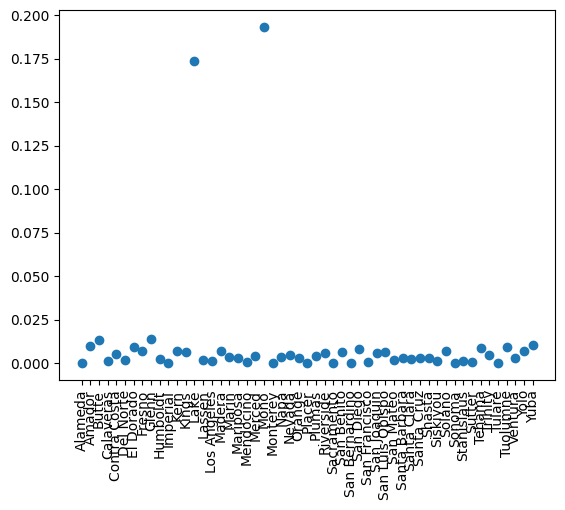

In [198]:
x1 = TD1['County']
y1 = TD1['IPC']

plt.scatter(x1, y1)
plt.xticks(rotation=90)


In [ ]:
plot2data = TD1[]

The control variables have a high degree of correlation between them, which could interfere with the estimates.

c:\Users\theod\AppData\Local\Programs\Python\Python312\Lib\site-packages\seaborn\matrix.py:202: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
c:\Users\theod\AppData\Local\Programs\Python\Python312\Lib\site-packages\seaborn\matrix.py:207: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)


<Axes: xlabel='None-County', ylabel='None-County'>

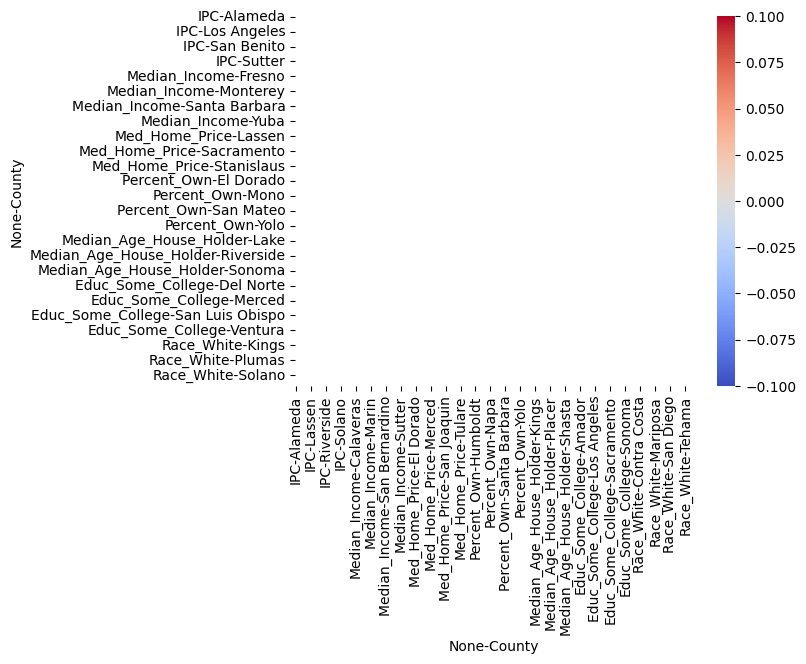

In [195]:
import numpy as np
import seaborn as sns
#xcorr = TD1.drop(columns='County')
corr = TD1.pivot(columns='County').corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr, mask = mask, annot=True, cmap="coolwarm")

# Analysis

In my first model, I am using a stepped-regression design to isolate the effect of each variable.

In [164]:
# Omitting County for analysis
TD2 = TD1.drop(columns={'County'})
TD2.columns

Index(['IPC', 'Median_Income', 'Med_Home_Price', 'Percent_Own',
       'Median_Age_House_Holder', 'Educ_Some_College', 'Race_White'],
      dtype='object')

In [165]:

# define x and y
y = TD2[['IPC']]
x = TD2[['Median_Income' , 'Med_Home_Price', 'Percent_Own' , 'Median_Age_House_Holder' , 'Educ_Some_College' , 'Race_White']]

# Container for coefs and p-values
xvars = ['Intercept', 'Median_Income' , 'Med_Home_Price', 'Percent_Own' , 'Median_Age_House_Holder' , 'Educ_Some_College' , 'Race_White']
rt2 = pd.DataFrame(np.nan, index=range(7), columns=range(1))
rt2 = (rt2
       .rename(columns={0: 'Variable'})
       .assign(Variable = xvars)
       .set_index('Variable'))

# step regression using forloop (this took me a long time to figure out)
for i in range(1, 7):
    j = 2*i - 7
    coefs = np.zeros(6)
    p_values = np.zeros(6)
    c = [x.columns[k] for k in range(i,6)]
    x1 = x.drop(c, axis=1)
    reg1 = sm.OLS(y, x1, const=False).fit()
    coefs = reg1.params
    coefs.rename(f'Test {i} Coefficient', inplace=True)
    rt2 = pd.concat([rt2, coefs], axis=1)
    p_values = reg1.pvalues
    p_values.rename(f'Test {i} P-Value', inplace=True)
    rt2 = pd.concat([rt2, p_values], axis=1)

# Display pretty regression table
from IPython.display import display
pd.options.display.float_format = '{:e}'.format # this keeps the numbers in scientific notation
rt2.fillna('', inplace=True)
display(rt2)


c:\Users\theod\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:130: ValueWarning: unknown kwargs ['const']
  warnings.warn(msg, ValueWarning)
c:\Users\theod\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:130: ValueWarning: unknown kwargs ['const']
  warnings.warn(msg, ValueWarning)
c:\Users\theod\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:130: ValueWarning: unknown kwargs ['const']
  warnings.warn(msg, ValueWarning)
c:\Users\theod\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:130: ValueWarning: unknown kwargs ['const']
  warnings.warn(msg, ValueWarning)
c:\Users\theod\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:130: ValueWarning: unknown kwargs ['const']
  warnings.warn(msg, ValueWarning)
c:\Users\theod\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:130: ValueW

,Test 1 Coefficient,Test 1 P-Value,Test 2 Coefficient,Test 2 P-Value,Test 3 Coefficient,Test 3 P-Value,Test 4 Coefficient,Test 4 P-Value,Test 5 Coefficient,Test 5 P-Value,Test 6 Coefficient,Test 6 P-Value
Intercept,,,,,,,,,,,,
Median_Income,2.841849e-07,3.812474e-02,4.411853e-07,2.458457e-01,-1.558119e-06,2.621305e-01,-1.564367e-06,2.652224e-01,-1.588955e-06,2.639572e-01,-1.353156e-06,3.613830e-01
Med_Home_Price,,,-1.005010e-08,6.564289e-01,3.956320e-08,3.227630e-01,4.079374e-08,3.228555e-01,4.644102e-08,3.383915e-01,4.125735e-08,4.050464e-01
Percent_Own,,,,,7.429800e-02,1.369500e-01,9.029204e-02,4.477668e-01,8.596842e-02,4.794686e-01,7.007925e-02,5.754138e-01
Median_Age_House_Holder,,,,,,,-1.915901e-04,8.818253e-01,-4.257074e-04,7.972743e-01,-7.578480e-04,6.665888e-01
Educ_Some_College,,,,,,,,,3.576898e-02,8.193924e-01,7.807444e-03,9.621255e-01
Race_White,,,,,,,,,,,4.136860e-02,5.489872e-01


hese results are much better than I was expecting. There is clearly a lot of correlation between these variables, especially with median income. P-values start very good with Test 1 and then quickly lose statistical significance as more variables are added. The effect of median income also flips from positive to negative, indicating that omitted variables were adding a significant amount of bias to the estimates.

If the above code is still not working by the time you read this, here are the results separately:

In [166]:
reg1 = smf.ols(formula = 'IPC ~ Median_Income', data = TD2).fit()
print(reg1.summary())


                            OLS Regression Results                            
Dep. Variable:                    IPC   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                 -0.017
Method:                 Least Squares   F-statistic:                    0.1558
Date:                Sat, 15 Jun 2024   Prob (F-statistic):              0.695
Time:                        22:09:54   Log-Likelihood:                 103.53
No. Observations:                  53   AIC:                            -203.1
Df Residuals:                      51   BIC:                            -199.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         0.0187      0.020      0.932

In [167]:
reg2 = smf.ols(formula = 'IPC ~ Median_Income + Percent_Own', data = TD2).fit()
print(reg2.summary())

                            OLS Regression Results                            
Dep. Variable:                    IPC   R-squared:                       0.017
Model:                            OLS   Adj. R-squared:                 -0.022
Method:                 Least Squares   F-statistic:                    0.4438
Date:                Sat, 15 Jun 2024   Prob (F-statistic):              0.644
Time:                        22:09:54   Log-Likelihood:                 103.92
No. Observations:                  53   AIC:                            -201.8
Df Residuals:                      50   BIC:                            -195.9
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        -0.0164      0.046     -0.359

In [170]:
reg3 = smf.ols(formula = 'IPC ~ Median_Income + Percent_Own + Median_Age_House_Holder', data = TD2).fit()
print(reg3.summary())

                            OLS Regression Results                            
Dep. Variable:                    IPC   R-squared:                       0.024
Model:                            OLS   Adj. R-squared:                 -0.036
Method:                 Least Squares   F-statistic:                    0.3992
Date:                Sat, 15 Jun 2024   Prob (F-statistic):              0.754
Time:                        22:11:38   Log-Likelihood:                 104.09
No. Observations:                  53   AIC:                            -200.2
Df Residuals:                      49   BIC:                            -192.3
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                 

In [ ]:
reg4 = smf.ols(formula = 'IPC ~ Median_Income + Percent_Own + Median_Age_House_Holder + Educ_Some_College', data = TD2).fit()
print(reg4.summary())

                            OLS Regression Results                            
Dep. Variable:              IPC_AFTER   R-squared:                       0.025
Model:                            OLS   Adj. R-squared:                 -0.057
Method:                 Least Squares   F-statistic:                    0.3046
Date:                Sat, 15 Jun 2024   Prob (F-statistic):              0.873
Time:                        16:43:51   Log-Likelihood:                 104.12
No. Observations:                  53   AIC:                            -198.2
Df Residuals:                      48   BIC:                            -188.4
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                 

In [ ]:
reg5 = smf.ols(formula = 'IPC ~ Median_Income + Percent_Own + Median_Age_House_Holder + Educ_Some_College + Race_White', data = TD2).fit()
print(reg5.summary())

                            OLS Regression Results                            
Dep. Variable:              IPC_AFTER   R-squared:                       0.033
Model:                            OLS   Adj. R-squared:                 -0.070
Method:                 Least Squares   F-statistic:                    0.3175
Date:                Sat, 15 Jun 2024   Prob (F-statistic):              0.900
Time:                        16:43:51   Log-Likelihood:                 104.33
No. Observations:                  53   AIC:                            -196.7
Df Residuals:                      47   BIC:                            -184.8
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                 

#### Test 2 - Random forest for feature importance

Given the small number of observations and the low p-values in the initial tests, predicting solar installations using machine learning is not feasible. However, I can use random forests to find the largest contributing factors in an alternative causal inference model.

In [ ]:
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import numpy as np

rf1 = RandomForestClassifier(n_estimators=100, max_depth=3, random_state=1)
x1 = [TD2['Median_Income']]
y = [TD2['IPC']]
rf1.fit(x1, y)



ValueError: Unknown label type: continuous-multioutput. Maybe you are trying to fit a classifier, which expects discrete classes on a regression target with continuous values.

In [ ]:
# Tree plot
plt.figure(figsize=(20, 10))  # Set the size of the figure
plot_tree(estimator, 
          feature_names=wine.feature_names, 
          class_names=wine.target_names, 
          filled=True, 
          rounded=True, 
          fontsize=10)
plt.show()

In [ ]:
# Feature importances
importances = rf1.feature_importances_
features = X.columns
indices = np.argsort(importances)

plt.figure(figsize=(10, 6))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

As of submission time, the random forest regression is not yet working. Given more time I will be able to figure out how to fit it to the data. This is a bit of an experimental application since this data is not well suited for RF models.

# Discussion

Results have high p-values and do not lend themselves to accurate causal inference or prediction models. A simple cross-sectional analysis of 53 California counties is simply not enough data to determine the main factors behind solar adoption with a high degree of certainty. However, some insights can be gleaned from test 1:

The lowest p-value is on Median_Income. Since income is highly correlated with age, education, race, and home ownership, this is not surprising. It is logical to believe that each of these is an important factor in the decision to adopt solar power, and the prevalence of these factors among the older, wealthier white population makes sense. Solar power systems are an expensive upfront investment and requires a high income and property ownership.

# References

Bureau, U. S. Census. n.d. “Annual Estimates of the Resident Population: April 1, 2010 to July 1, 2019.” U.S. Census Bureau. https://data.census.gov/table/PEPPOP2019.PEPANNRES?q=California&t=Population
Total&g=040XX00US06$0500000&y=2019

“Distributed Generation Statistics.” n.d. California Public Utilities Commission. https://www.californiadgstats.ca.gov/.

“Median Home Time on Market Monthly Historical Data.” n.d. California Association of Realtors

Ybarra, Candace E., John B. Broughton, and Prashanth U. Nyer. 2021. “Trends in the Installation of Residential Solar Panels in California.” Scientific Research Publishing.
